In [0]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch

from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [0]:
path ='/content/drive/My Drive/dataset/kaggle/chest/chest-xray-pneumonia.zip'

In [0]:
!unzip '/content/drive/My Drive/dataset/kaggle/chest-xray-pneumonia.zip'

In [0]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),#从中心开始裁剪
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'test': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
batch_size = 32
dir_path = '/content/chest_xray/'
image_datasets = {x: datasets.ImageFolder(os.path.join(dir_path, x), data_transforms[x]) for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [6]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fe1bd21e630>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fe1bd21e198>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fe1bd21e518>}

In [7]:
class_names

['NORMAL', 'PNEUMONIA']

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs,classes = next(iter(dataloaders["val"]))

In [9]:
inputs

tensor([[[[-1.7240, -1.7583, -1.7754,  ..., -1.8268, -1.8097, -1.7925],
          [-1.6898, -1.7240, -1.7412,  ..., -1.7925, -1.7754, -1.7583],
          [-1.6384, -1.6898, -1.7069,  ..., -1.7412, -1.7240, -1.6898],
          ...,
          [ 1.1872,  1.2214,  1.2043,  ...,  0.2453, -0.0801, -0.1314],
          [ 1.2043,  1.2214,  1.2043,  ...,  0.2111, -0.0629, -0.1143],
          [ 1.1872,  1.2214,  1.2214,  ...,  0.2111, -0.0629, -0.1486]],

         [[-1.6331, -1.6681, -1.6856,  ..., -1.7381, -1.7206, -1.7031],
          [-1.5980, -1.6331, -1.6506,  ..., -1.7031, -1.6856, -1.6681],
          [-1.5455, -1.5980, -1.6155,  ..., -1.6506, -1.6331, -1.5980],
          ...,
          [ 1.3431,  1.3782,  1.3606,  ...,  0.3803,  0.0476, -0.0049],
          [ 1.3606,  1.3782,  1.3606,  ...,  0.3452,  0.0651,  0.0126],
          [ 1.3431,  1.3782,  1.3782,  ...,  0.3452,  0.0651, -0.0224]],

         [[-1.4036, -1.4384, -1.4559,  ..., -1.5081, -1.4907, -1.4733],
          [-1.3687, -1.4036, -

In [10]:
classes 

tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1])

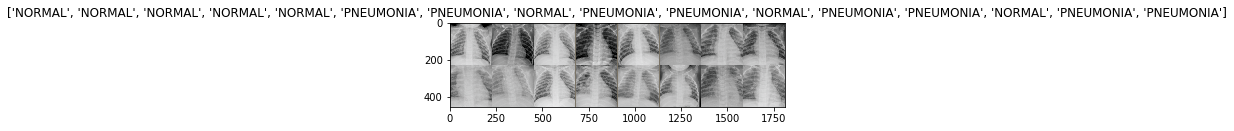

In [11]:
out = torchvision.utils.make_grid(inputs)
class_names = image_datasets["val"].classes
imshow(out, title = [class_names[x] for x in classes])

# {'NORMAL'：0 , 'PNEUMONIA'：1}

In [12]:
class_names

['NORMAL', 'PNEUMONIA']

In [0]:
model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True 

In [14]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [15]:
device

device(type='cuda', index=0)

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
model_ft = models.resnet101()
model_ft

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 102),
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [19]:
model_ft, input_size = initialize_model(model_name, 2, feature_extract, use_pretrained=True)

#GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



Params to learn:
	 fc.0.weight
	 fc.0.bias


In [0]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss()

In [21]:
 optimizer_ft.param_groups[0]

{'amsgrad': False,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'initial_lr': 0.01,
 'lr': 0.01,
 'params': [Parameter containing:
  tensor([[ 0.0158,  0.0114,  0.0178,  ...,  0.0056, -0.0073,  0.0070],
          [-0.0027, -0.0035, -0.0131,  ..., -0.0218,  0.0193,  0.0196],
          [ 0.0121,  0.0140,  0.0053,  ...,  0.0122, -0.0108, -0.0001],
          ...,
          [-0.0109,  0.0093,  0.0008,  ...,  0.0125, -0.0051, -0.0153],
          [-0.0136, -0.0058, -0.0020,  ..., -0.0075, -0.0135,  0.0095],
          [ 0.0190, -0.0088,  0.0053,  ...,  0.0140, -0.0160, -0.0184]],
         device='cuda:0', requires_grad=True), Parameter containing:
  tensor([-0.0013, -0.0212,  0.0118,  0.0199,  0.0058, -0.0104, -0.0112,  0.0099,
           0.0022,  0.0035,  0.0115, -0.0188,  0.0030,  0.0159, -0.0193, -0.0129,
          -0.0135,  0.0008,  0.0211,  0.0168,  0.0047,  0.0184, -0.0085,  0.0023,
          -0.0041,  0.0024, -0.0144, -0.0192, -0.0047, -0.0039,  0.0154,  0.0024,
           0.0145,  0.0106, -

In [22]:
 optimizer_ft.param_groups[0]['lr']

0.01

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename):
    since = time.time()
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'test':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

In [0]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=80, is_inception=(model_name=="inception"))

In [0]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(params_to_update, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.NLLLoss()

In [0]:
#----------------# Load the checkpoint

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
#model_ft.class_to_idx = checkpoint['mapping']

In [27]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=33, is_inception=(model_name=="inception"))

Epoch 0/32
----------
Time elapsed 2m 43s
train Loss: 0.5569 Acc: 0.9168
Time elapsed 2m 55s
test Loss: 1.4224 Acc: 0.8365


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Optimizer learning rate : 0.0100000

Epoch 1/32
----------
Time elapsed 5m 38s
train Loss: 0.4364 Acc: 0.9279
Time elapsed 5m 50s
test Loss: 1.2248 Acc: 0.8494
Optimizer learning rate : 0.0100000

Epoch 2/32
----------
Time elapsed 8m 33s
train Loss: 0.2826 Acc: 0.9448
Time elapsed 8m 46s
test Loss: 1.0012 Acc: 0.8638
Optimizer learning rate : 0.0100000

Epoch 3/32
----------
Time elapsed 11m 29s
train Loss: 0.3544 Acc: 0.9344
Time elapsed 11m 41s
test Loss: 1.4896 Acc: 0.8173
Optimizer learning rate : 0.0100000

Epoch 4/32
----------
Time elapsed 14m 24s
train Loss: 0.2890 Acc: 0.9429
Time elapsed 14m 36s
test Loss: 0.7926 Acc: 0.8782
Optimizer learning rate : 0.0100000

Epoch 5/32
----------
Time elapsed 17m 19s
train Loss: 0.4393 Acc: 0.9229
Time elapsed 17m 32s
test Loss: 0.8510 Acc: 0.8878
Optimizer learning rate : 0.0100000

Epoch 6/32
----------
Time elapsed 20m 14s
train Loss: 0.3312 Acc: 0.9363
Time elapsed 20m 27s
test Loss: 0.8966 Acc: 0.8622
Optimizer learning rate : 0.0100

In [43]:
"""
probs, classes = predict(image_path, model)
print(probs)
print(classes)
"""

'\nprobs, classes = predict(image_path, model)\nprint(probs)\nprint(classes)\n'

In [31]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='checkpoint.pth'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [0]:
def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))
    
    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

In [0]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [36]:
output.shape

torch.Size([16, 102])

In [0]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [37]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1])

In [0]:
cat_to_name={'0':'NORMAL',
             '1': 'PNEUMONIA'}
             # # {'NORMAL'：0 , 'PNEUMONIA'：1}

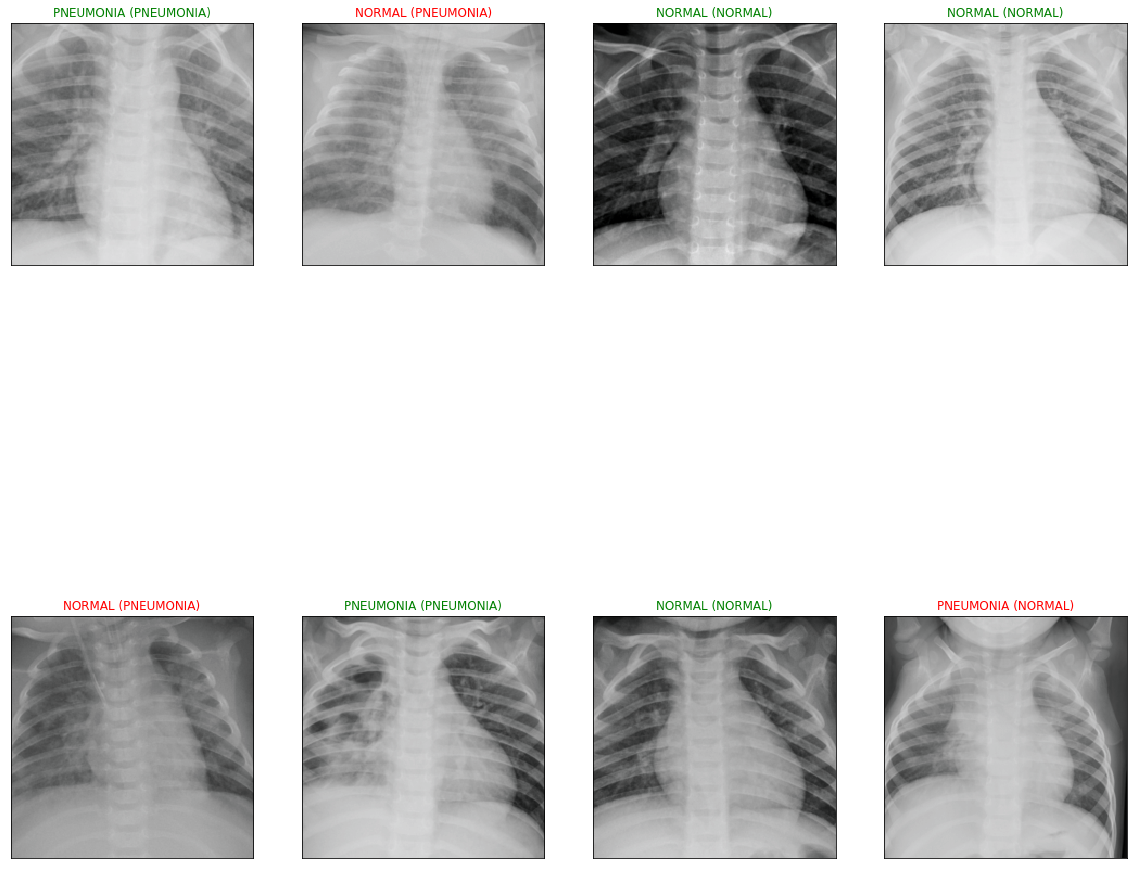

In [42]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()